#  ***Identificação de Ataques DDoS com Machine Learning (PT) || DDoS Attacks Identification with Machine Learning (EN)***

### ***Importando bibliotecas e carregando a base de dados (PT) || Importing libraries and loading the database (EN)***

Inicialmente vamos carregar algumas blibiotecas utéis para este projeto juntamente com as bases de dados (PT)

Initially we will load some useful libraries for this project together with the databases (EN)

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

#Nomes das colunas do dataset (PT) || Datase columns names (EN)
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack","level"]

#Caminho e definição do dataset (PT) || Dataset path and definition (EN)
train_data_path = "/DDOS Detection/Dataset/KDDTrain+.txt"
train_data = pd.read_csv(train_data_path, header=None, names = col_names, index_col=False)
#C:\Users\joaov\OneDrive\Área de Trabalho\Python\DDOS Detection\Dataset
test_data_path = "/DDOS Detection/Dataset/KDDTest+.txt"
test_data = pd.read_csv(test_data_path, header=None, names = col_names, index_col=False)

pd.set_option('display.max_columns', None)

### ***Exploratory Analysis 1 (EN) || Análise Exploratória 1 (PT)***

Agora podemos dar uma olhada geral nos nossos dados para identificar pontos que serão relevantes na etapa de pré processamento (PT)

- Quantas colunas contém dados sem valores
- Qual o tipo de dado dessas colunas

Now we can take a general look at our data to identify points that will be relevant in the pre-processing stage (EN)

- How many columns contain data without values
- What is the data type of these columns

In [2]:
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
# How many rows and columns (EN) || Quantas linhas e colunas (PT)
train_data.shape

(125973, 43)

In [4]:
# Split numerical and categorical data for better analysis (EN)
# Separando dados numéricos e categóricos para uma melhor análise (PT)
train_data_num = train_data.select_dtypes(include=['float64','int64'])
train_data_categ = train_data.select_dtypes(exclude=['float64','int64'])

In [5]:
# Describing numerical data: mean, standard deviation, min, max and quartiles (EN)
# Descrição de dados numéricos: média, desvio padrão, mínimo, máximo e quartis (PT)
train_data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [6]:
# Describing categorical data: unique values and most frequent (EN)
# Descrição de dados categóricos: valores únicos e mais frequentes (PT)
train_data_categ.describe().T

,count,unique,top,freq
protocol_type,125973,3,tcp,102689
service,125973,70,http,40338
flag,125973,11,SF,74945
attack,125973,23,normal,67343


**Só temos 4 parâmetros com valores não-numéricos (PT)**
- 'protocol_type': Tipo do protocolo utilizado na conexão
- 'service': Serviço de rede de destino usado
- 'flag': Status da conexão
- 'attack': Classificação do tipo de conexão (normal, malicioso)

**We only have 4 parameters with non-numeric values (EN)**
- 'protocol_type': Type of protocol used in the connection
- 'service': Target network service used
- 'flag': Connection status
- 'attack': Classification of connection type (normal, malicious)

### ***Etapa de pré-processamento: limpeza de dados e engenharia de recursos (PT) || Preprocessing step: data cleaning and feature engineering (EN)***

Etapa onde vamos substituir os parâmetros categóricos por numéricos (PT)

Step where we will replace categorical parameters with numeric ones (EN)

In [27]:
# Agrupando os tipos de ataques (PT) || Grouping attacks types (EN)
ataques_dos = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
ataques_probe = ['ipsweep','mscan','nmap','portsweep','saint','satan']
ataques_privilegio = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']
ataques_acesso = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

tipos_ataque = ['Normal', 'DoS', 'Probe', 'Privilegio', 'Acesso']

# Mapeamento e classificação de cada ataque à um tipo da lista acima (Ordinal encoding) (PT) || Mapping and classification of each attack to a type from the list above (Ordinal encoding) (EN)
def ataque_map(ataque):
    if ataque in ataques_dos:
        tipo_ataque = 'DoS'
    elif ataque in ataques_probe:
        tipo_ataque = 'Probe'
    elif ataque in ataques_privilegio:
        tipo_ataque = 'Privilege'
    elif ataque in ataques_acesso:
        tipo_ataque = 'Access'
    else:
        tipo_ataque = 'Normal'    
    return tipo_ataque

tipos_ataques_train = train_data['attack'].apply(ataque_map)
train_data['Attack Type'] = tipos_ataques_train
tipos_ataques_test = test_data['attack'].apply(ataque_map)
test_data['Attack Type'] = tipos_ataques_test
train_data.head(10)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,Attack Type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,Normal
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21,DoS
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS
8,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS
9,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,DoS


In [23]:
train_data = train_data[train_data['Attack Type'].isin(['Normal', 'DoS'])]
test_data = test_data[test_data['Attack Type'].isin(['Normal', 'DoS'])]
train_data_categ = train_data.select_dtypes(exclude=['int64', 'float64'])
train_data_num = train_data.select_dtypes(include=['int64', 'float64'])


In [9]:
train_data_num.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,113279.000000,1.132790e+05,1.132790e+05,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.0,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.000000,113279.00000,113279.000000
mean,100.228577,8.284507e+03,2.642785e+03,0.000221,0.025230,0.000088,0.153374,0.000821,0.430989,0.309289,0.001236,0.001218,0.334678,0.013356,0.000397,0.004467,0.0,0.000009,0.007707,85.590286,29.698841,0.311454,0.309911,0.087943,0.088563,0.654140,0.043650,0.077218,186.815720,123.876570,0.532756,0.050769,0.092489,0.016138,0.311513,0.305454,0.091580,0.08791,19.907547
std,1009.169332,3.224676e+05,5.052047e+04,0.014854,0.267238,0.013287,1.791038,0.038157,0.495217,25.247311,0.035134,0.047523,25.729380,0.502793,0.021627,0.104277,0.0,0.002971,0.087449,109.510198,76.109174,0.459762,0.459245,0.281199,0.281045,0.441104,0.120851,0.220625,95.550806,111.847781,0.444782,0.106596,0.232906,0.057001,0.458762,0.458107,0.279067,0.27632,1.688959
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,96.000000,13.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,19.000000
50%,0.000000,5.900000e+01,3.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,17.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,84.000000,0.580000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,21.000000
75%,0.000000,2.900000e+02,7.600000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,147.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.030000,0.010000,1.000000,1.000000,0.000000,0.00000,21.000000
max,40504.000000,8.958152e+07,7.028652e+06,1.000000,3.000000,3.000000,77.000000,4.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,21.000000


In [10]:
train_data_categ.describe().T

,count,unique,top,freq
protocol_type,113279,3,tcp,95797
service,113279,65,http,40304
flag,113279,10,SF,68001
attack,113279,8,normal,67343
Attack Type,113279,2,Normal,67352


In [11]:
# How many missing values (EN) || Contagem de valores faltantes por coluna (PT)
missing_values = train_data.isnull().sum()
print(missing_values[missing_values>0])

Series([], dtype: int64)


Não existem linhas com valores faltantes (PT) || There are no lines with missing values (EN)

### ***Exploratory Analysis 2 (EN) || Análise Exploratória 2 (PT)***

Com a identificação dos tipos de ataques feita na etapa de engenharia de recursos, podemos analisar mais detalhadamente os dados (PT)

By identifying the types of attacks carried out in the resource engineering stage, we can analyze the data in more detail (EN)

In [4]:
# Bar graph function (EN) || Função para criaçãao de grafico  de barra (PT)
def plot_bar(df, name_x='X', name_y='Y', name_graph='Graph', largura=10, altura=6):
    x = df.index
    y = df.values
    colors = ['deepskyblue']
    plt.figure(figsize=(12, 8))
    bars = plt.bar(x, y, color=colors, width=0.5)
    for bar, valor in zip(bars, y):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(valor), 
                ha='center', va='bottom')
    plt.xticks(range(len(x)), x, rotation=45)
    plt.xlabel(name_x)
    plt.ylabel(name_y)
    plt.title(name_graph)
    plt.show

# Pizza graph function (EN) || Função para criação de grafico pizza (PT)
def plot_pizza(df, name_x='X', name_y='Y', name_graph='Graph'):
    x = df.index
    y = df.values
    plt.figure(figsize=(10, 10))
    plt.pie(y, labels=x, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, labeldistance=1.1)
    plt.title(name_graph)
    plt.axis('equal')  

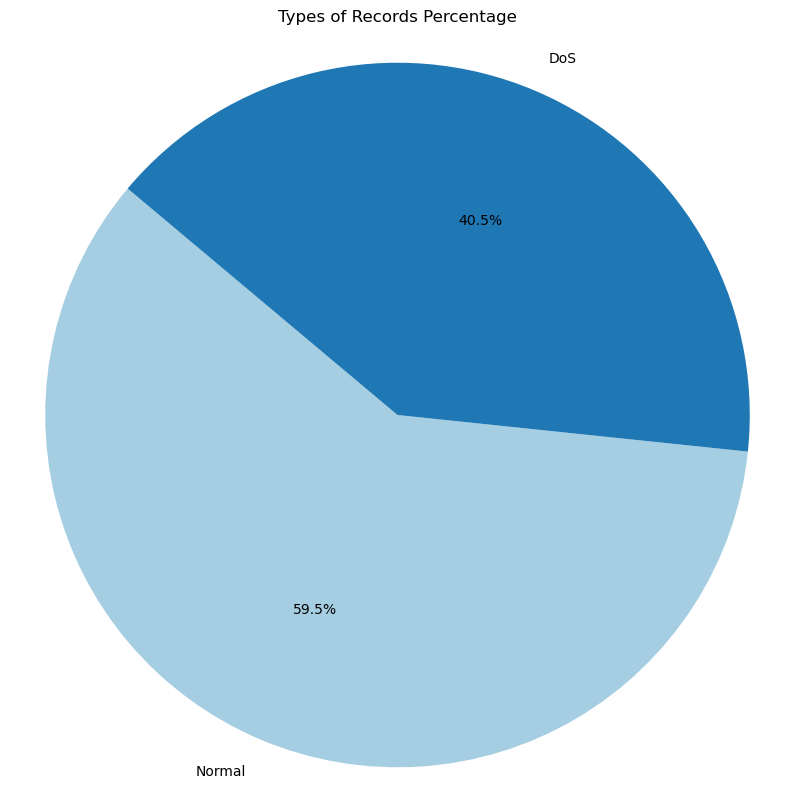

In [28]:
# Proporção de acessos maliciosos (PT) || Proportion of malicious accesses (EN)
df = train_data['Attack Type'].value_counts()
plot_pizza(df, name_graph='Types of Records Percentage')

<Axes: >

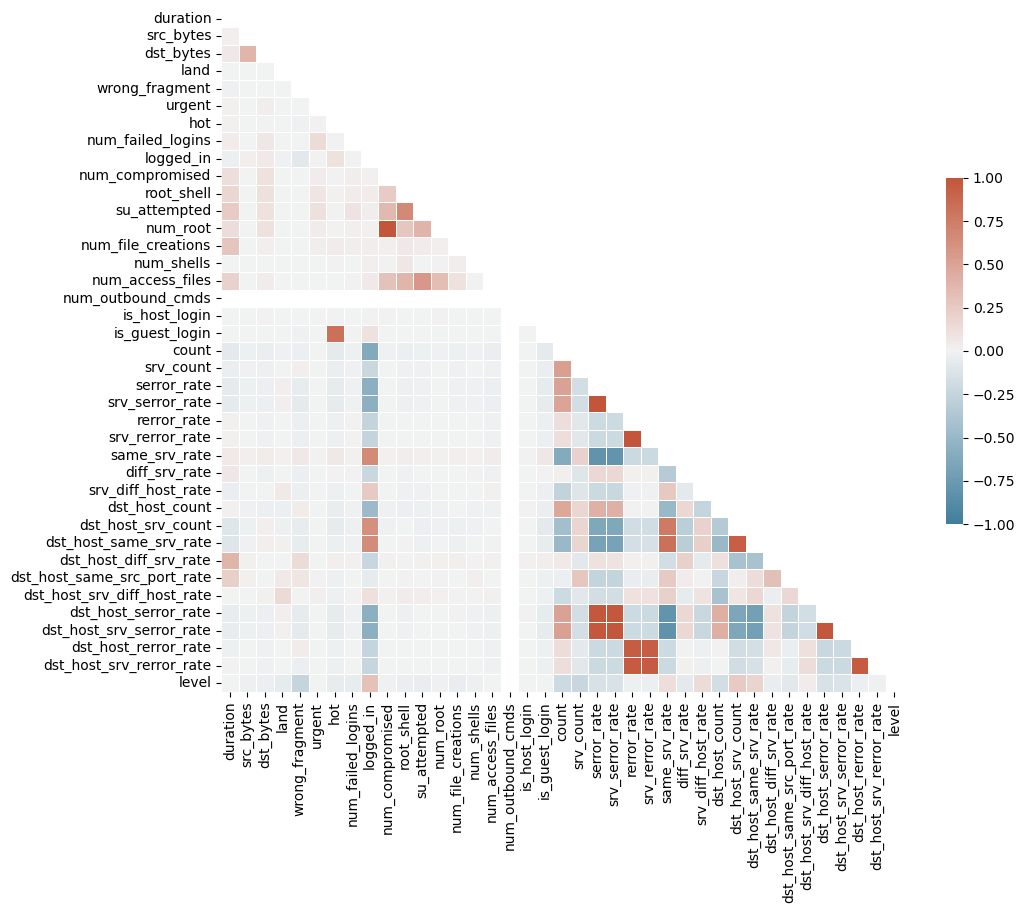

In [15]:
# Análise da Matriz de Correlação (PT) || Correlation Matrix Analysis (EN)
corr = train_data_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
corr_matrix = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1 ,vmax=1, center=0, 
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_matrix

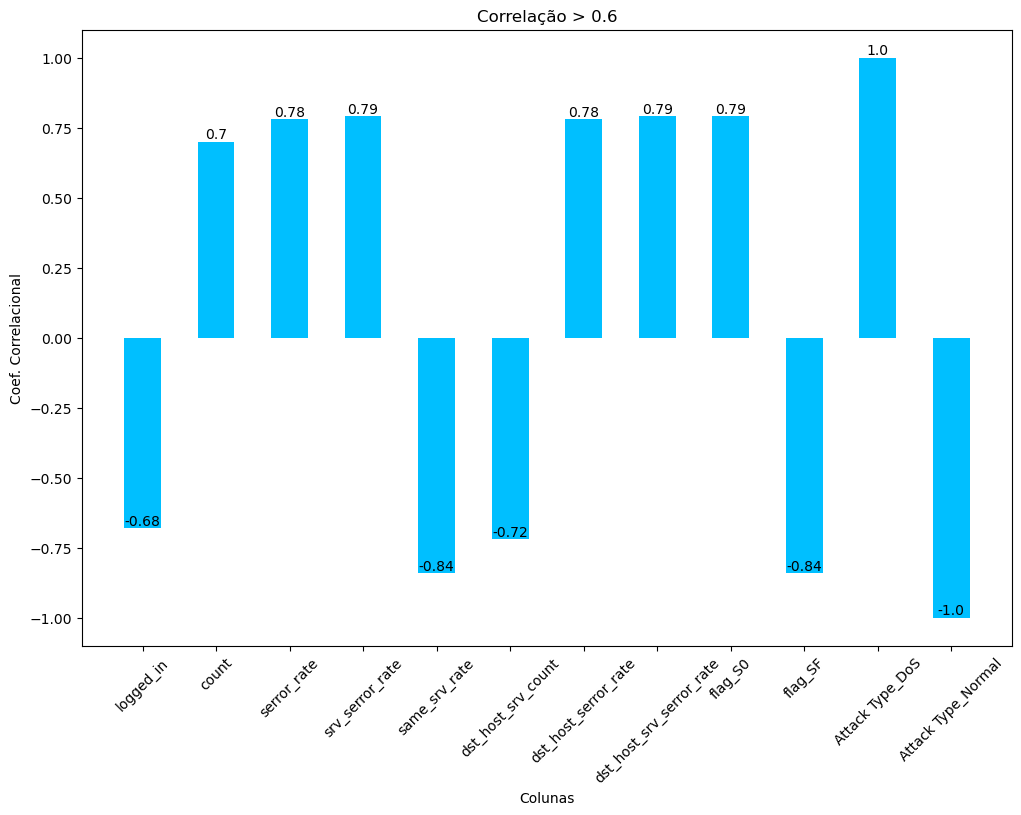

In [16]:
#Verifying the correlational coeficient of the numerical columns (EN) 
#Verificando o coeficiente correlacional das colunas numéricas (PT)
train_data_dumm = pd.get_dummies(train_data.drop('attack', axis=1)).astype('int')
correlacao = train_data_dumm.corr().round(2)      
correlacao = correlacao['Attack Type_DoS']
correlacao = correlacao[abs(correlacao) > 0.6]
plot_bar(correlacao, name_graph='Correlação > 0.6', name_x='Colunas', name_y='Coef. Correlacional')

Através da matriz de correlação pode-se notar que existem variáveis independentes fortemente correlacionadas, acrescentando redundância a nossa base.
Abaixo iremos identificar essas colunas e retirar as que têm o menor coeficiente de correlação com a variável alvo (PT)

Through the correlation matrix it can be seen that there are independent variables that are strongly correlated, adding redundancy to our base.
Below we will identify these columns and remove those that have the lowest correlation coefficient with the target variable (EN)

In [17]:
correlation_data = train_data_num.corr()

correlation_df = pd.DataFrame(correlation_data.unstack().sort_values(ascending=False), 
                              columns=['Correlation'])

# Exclusão de pares duplicados (correlação de A com B é a mesma que a correlação de B com A) (PT) || Deletion of duplicate pairs (correlation of A with B is the same as the correlation of B with A) (EN)
correlation_df = correlation_df[correlation_df.index.get_level_values(0) != correlation_df.index.get_level_values(1)]

# Correlações em ordem decrescente (PT) || Correlations in descending order (EN)
correlation_df_sorted = correlation_df.sort_values(by='Correlation', ascending=False)
correlation_df.index.names = ['Feature 1', 'Feature 2']

# Selecionar apenas as correlações maiores que 0.80 (PT) || Select only correlations greater than 0.80 (EN)
highly_correlated = correlation_df[correlation_df['Correlation'] > 0.80].reset_index()

highly_correlated = highly_correlated.drop_duplicates()
highly_correlated

,Feature 1,Feature 2,Correlation
0,num_root,num_compromised,0.998838
1,num_compromised,num_root,0.998838
2,serror_rate,srv_serror_rate,0.995329
3,srv_serror_rate,serror_rate,0.995329
4,rerror_rate,srv_rerror_rate,0.993341
5,srv_rerror_rate,rerror_rate,0.993341
6,dst_host_srv_serror_rate,dst_host_serror_rate,0.987639
7,dst_host_serror_rate,dst_host_srv_serror_rate,0.987639
8,dst_host_srv_serror_rate,srv_serror_rate,0.985717
9,srv_serror_rate,dst_host_srv_serror_rate,0.985717


In [18]:
a = highly_correlated['Feature 1'].drop_duplicates().to_list()
b = highly_correlated['Feature 2'].drop_duplicates().to_list()

columns = []
for i in a:
    columns.append(i)
for i in b:
    columns.append(i)

columns1 = ['Attack Flag']
for item in columns:
    if item not in columns1:
        columns1.append(item)

train_data_num['Attack Flag'] = pd.get_dummies(train_data)['Attack Type_DoS'].astype('int')
correlacao1 = train_data_num[columns1].corr().round(2)      
correlacao1 = correlacao1['Attack Flag']
correlacao_dict = correlacao1.to_dict()
correlacao1_df = pd.DataFrame(correlacao1)
correlacao1_df.index.names = ['Feature']

In [19]:
highly_correlated['Correlation Feature 1'] = highly_correlated['Feature 1'].map(correlacao_dict)
highly_correlated['Correlation Feature 2'] = highly_correlated['Feature 2'].map(correlacao_dict)
highly_correlated

,Feature 1,Feature 2,Correlation,Correlation Feature 1,Correlation Feature 2
0,num_root,num_compromised,0.998838,-0.01,-0.01
1,num_compromised,num_root,0.998838,-0.01,-0.01
2,serror_rate,srv_serror_rate,0.995329,0.78,0.79
3,srv_serror_rate,serror_rate,0.995329,0.79,0.78
4,rerror_rate,srv_rerror_rate,0.993341,0.19,0.19
5,srv_rerror_rate,rerror_rate,0.993341,0.19,0.19
6,dst_host_srv_serror_rate,dst_host_serror_rate,0.987639,0.79,0.79
7,dst_host_serror_rate,dst_host_srv_serror_rate,0.987639,0.79,0.79
8,dst_host_srv_serror_rate,srv_serror_rate,0.985717,0.79,0.79
9,srv_serror_rate,dst_host_srv_serror_rate,0.985717,0.79,0.79


In [20]:
highly_correlated['Correlation Feature 1'] = abs(highly_correlated['Correlation Feature 1'])
highly_correlated['Correlation Feature 2'] = abs(highly_correlated['Correlation Feature 2'])
highly_correlated['Maior Correlação'] = highly_correlated.apply(lambda row: 'iguais' if row['Correlation Feature 1'] == row['Correlation Feature 2']
                                   else ('Feature 1' if row['Correlation Feature 1'] > row['Correlation Feature 2'] else 'Feature 2'), axis=1)
filtered_df = highly_correlated.loc[highly_correlated['Maior Correlação'].isin(['Feature 1', 'Feature 2'])]
filtered_df

,Feature 1,Feature 2,Correlation,Correlation Feature 1,Correlation Feature 2,Maior Correlação
2,serror_rate,srv_serror_rate,0.995329,0.78,0.79,Feature 2
3,srv_serror_rate,serror_rate,0.995329,0.79,0.78,Feature 1
10,serror_rate,dst_host_srv_serror_rate,0.982669,0.78,0.79,Feature 2
11,dst_host_srv_serror_rate,serror_rate,0.982669,0.79,0.78,Feature 1
14,serror_rate,dst_host_serror_rate,0.979642,0.78,0.79,Feature 2
15,dst_host_serror_rate,serror_rate,0.979642,0.79,0.78,Feature 1
20,dst_host_srv_rerror_rate,dst_host_rerror_rate,0.955721,0.19,0.20,Feature 2
21,dst_host_rerror_rate,dst_host_srv_rerror_rate,0.955721,0.20,0.19,Feature 1
22,dst_host_rerror_rate,rerror_rate,0.949360,0.20,0.19,Feature 1
23,rerror_rate,dst_host_rerror_rate,0.949360,0.19,0.20,Feature 2


Definição de quais colunas serão excluídas (PT) || Defining which columns will be excluded (EN)

In [21]:
drop_high_corr = ['serror_rate', 'dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'hot']

In [35]:
train_data['DoS'] = pd.get_dummies(train_data['Attack Type']).astype('int')['DoS']
train_data_num = train_data.select_dtypes(include=['int', 'float']).drop('level', axis=1)
train_data_categ = train_data.select_dtypes(exclude=['int', 'float']).drop(['attack','Attack Type'], axis=1)

C:\Users\joaov\AppData\Local\Temp\ipykernel_5704\1368647359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['DoS'] = pd.get_dummies(train_data['Attack Type']).astype('int')['DoS']


In [36]:
#Numerical and catergorical transformers (EN) || Transformers categóricos e numéricos (PT).

numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

numerical_columns = train_data_num.drop('DoS', axis=1).columns
categorical_columns = train_data_categ.columns

#Preprocessor (EN) || Preprocessador (PT)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

preprocessor_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)])

#Aplying to the data and spliting into x and y (EN) || Aplicando aos nossos dados e separando x e y (PT)
x = train_data.drop(['DoS', 'level', 'attack', 'Attack Type'], axis=1)
y = train_data['DoS']
x_prep = preprocessor_pipe.fit_transform(x)

c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
train_X, val_X, train_Y, val_Y = train_test_split(x_prep, y, random_state=0, train_size=0.7)

### ***Definição e Treinamento dos Modelos (PT) || Model Definition and Training (EN)***

Na última etapa vamos definir os modelos de machine learning a serem utilizados e treinar estes modelos com diferentes subconjuntos de dados (PT)

In the last step we will define the machine learning models to be used and train these models with different subsets of data (EN)

#### **Modelos Utilizados (PT) || Models Used (EN)**:
- LogisticRegression
- RandomForestCLassifier
- SVC
- KMeans
- MLPClassifier

#### **Bases Utilizadas (PT) || Bases Used (EN)**
- Base completa || Complete base
- Base excluindo colunas redundantes || Base excluding redundant columns
- Base apenas com colunas de alta correlação || Base only with high correlation columns
- Base PCA || PCA Base

## **Base Completa || Complete Base**

In [30]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegressor': LogisticRegression(random_state=42, dual=False),
    'KMeans': KMeans(random_state=42, verbose=0),
    'MLPClassifier': MLPClassifier(random_state=42,max_iter=10000, n_iter_no_change = 3,learning_rate_init=0.001),
    'SVC': SVC(random_state=42, tol=50)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 50],
        'min_samples_split': [2, 5, 10],
    },
    'LogisticRegressor': {
        'penalty': ['l1', 'l2', 'none'],
        'solver': ['sag', 'newton-cg', 'lbfgs'],
        'max_iter': [100, 300, 500],
    },
    'KMeans': {
        'n_clusters': [2, 4, 8],
        'init': ['random', 'k-means++'],
        'n_init': [1, 5, 10],
        'max_iter': [300, 500],
        'algorithm': ['lloyd', 'elkan']
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        'C': [1, 5, 10],
        'kernel': ['linear'],
        'gamma': ['scale', 'auto']
    }
}

# 3-fold cross-validation (EN) || Validação cruzada tripla (PT)
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Training and calculating the error of the models (EN) || Treinando e calculando o erro dos modelos (PT)
grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, 
                                     scoring=scoring, refit='f1_score', n_jobs=-1, verbose=2)
    grids[model_name].fit(train_X, train_Y)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")
    

Fitting 2 folds for each of 27 candidates, totalling 54 fits

Melhores resultados para RandomForest:
Melhor combinação de parâmetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}
  Accuracy: Média = 0.9998, Desvio Padrão = 0.0001
  Precision: Média = 0.9998, Desvio Padrão = 0.0002
  Recall: Média = 0.9997, Desvio Padrão = 0.0000
  F1_score: Média = 0.9998, Desvio Padrão = 0.0001
Fitting 2 folds for each of 27 candidates, totalling 54 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _c


Melhores resultados para LogisticRegressor:
Melhor combinação de parâmetros: {'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
  Accuracy: Média = 0.9966, Desvio Padrão = 0.0002
  Precision: Média = 0.9957, Desvio Padrão = 0.0025
  Recall: Média = 0.9959, Desvio Padrão = 0.0019
  F1_score: Média = 0.9958, Desvio Padrão = 0.0003
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.20409744 0.20409744 0.20409744        nan        nan        nan
        nan        nan        nan 0.20409744 0.20409744 0.20409744
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan
 0.20409744 0.20409744 0.20409744        nan        nan        nan
        nan        nan        nan 0.20409744 0.20409744 0.20409744
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\


Melhores resultados para KMeans:
Melhor combinação de parâmetros: {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 300, 'n_clusters': 2, 'n_init': 1}
  Accuracy: Média = 0.4991, Desvio Padrão = 0.0867
  Precision: Média = 0.2041, Desvio Padrão = 0.2041
  Recall: Média = 0.5000, Desvio Padrão = 0.5000
  F1_score: Média = 0.2899, Desvio Padrão = 0.2899
Fitting 2 folds for each of 36 candidates, totalling 72 fits

Melhores resultados para MLPClassifier:
Melhor combinação de parâmetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
  Accuracy: Média = 0.9997, Desvio Padrão = 0.0000
  Precision: Média = 0.9994, Desvio Padrão = 0.0001
  Recall: Média = 0.9998, Desvio Padrão = 0.0000
  F1_score: Média = 0.9996, Desvio Padrão = 0.0000
Fitting 2 folds for each of 6 candidates, totalling 12 fits

Melhores resultados para SVC:
Melhor combinação de parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: Média = 0.4064, Desvio Padrão

## **PCA**

In [40]:
pca = PCA()
X_pca_pre = pca.fit_transform(x_prep)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

pca = PCA(n_components=n_components)
pipeline_pca = Pipeline(steps=
                        [('preprocessor', preprocessor),
                        ('pca', pca)])

x = train_data.drop(['DoS', 'level', 'attack', 'Attack Type'], axis=1)
y = train_data['DoS']
x_pca = pipeline_pca.fit_transform(x)
train_X_pca, val_X_pca, train_Y_pca, val_Y_pca = train_test_split(x_pca, y, test_size=0.3, random_state=42)

c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegressor': LogisticRegression(random_state=42, dual=False),
    'KMeans': KMeans(random_state=42, verbose=0),
    'MLPClassifier': MLPClassifier(random_state=42,max_iter=10000, n_iter_no_change = 3,learning_rate_init=0.001),
    'SVC': SVC(random_state=42, tol=50)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 50],
        'min_samples_split': [2, 5, 10],
    },
    'LogisticRegressor': {
        'penalty': ['l1', 'l2', 'none'],
        'solver': ['sag', 'newton-cg', 'lbfgs'],
        'max_iter': [100, 300, 500],
    },
    'KMeans': {
        'n_clusters': [2, 4, 8],
        'init': ['random', 'k-means++'],
        'n_init': [1, 5, 10],
        'max_iter': [300, 500],
        'algorithm': ['lloyd', 'elkan']
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        'C': [1, 5, 10],
        'kernel': ['linear'],
        'gamma': ['scale', 'auto']
    }
}

# 3-fold cross-validation (EN) || Validação cruzada tripla (PT)
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Training and calculating the error of the models (EN) || Treinando e calculando o erro dos modelos (PT)
grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, 
                                     scoring=scoring, refit='f1_score', n_jobs=-1, verbose=2)
    grids[model_name].fit(train_X_pca, train_Y_pca)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")


Fitting 2 folds for each of 27 candidates, totalling 54 fits

Melhores resultados para RandomForest:
Melhor combinação de parâmetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
  Accuracy: Média = 0.9968, Desvio Padrão = 0.0000
  Precision: Média = 0.9968, Desvio Padrão = 0.0007
  Recall: Média = 0.9953, Desvio Padrão = 0.0006
  F1_score: Média = 0.9960, Desvio Padrão = 0.0001
Fitting 2 folds for each of 27 candidates, totalling 54 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _c


Melhores resultados para LogisticRegressor:
Melhor combinação de parâmetros: {'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
  Accuracy: Média = 0.4206, Desvio Padrão = 0.0021
  Precision: Média = 0.4097, Desvio Padrão = 0.0020
  Recall: Média = 0.9798, Desvio Padrão = 0.0003
  F1_score: Média = 0.5778, Desvio Padrão = 0.0020
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.40749664 0.40749664 0.40749664        nan        nan        nan
        nan        nan        nan 0.40749664 0.40749664 0.40749664
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan
 0.40749664 0.40749664 0.40749664        nan        nan        nan
        nan        nan        nan 0.40749664 0.40749664 0.40749664
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\


Melhores resultados para KMeans:
Melhor combinação de parâmetros: {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 300, 'n_clusters': 2, 'n_init': 1}
  Accuracy: Média = 0.4117, Desvio Padrão = 0.0019
  Precision: Média = 0.4075, Desvio Padrão = 0.0018
  Recall: Média = 1.0000, Desvio Padrão = 0.0000
  F1_score: Média = 0.5790, Desvio Padrão = 0.0019
Fitting 2 folds for each of 36 candidates, totalling 72 fits

Melhores resultados para MLPClassifier:
Melhor combinação de parâmetros: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
  Accuracy: Média = 0.9206, Desvio Padrão = 0.0007
  Precision: Média = 0.8890, Desvio Padrão = 0.0001
  Recall: Média = 0.9183, Desvio Padrão = 0.0010
  F1_score: Média = 0.9034, Desvio Padrão = 0.0005
Fitting 2 folds for each of 6 candidates, totalling 12 fits

Melhores resultados para SVC:
Melhor combinação de parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: Média = 0.4046, Desvio Padrão

## **CORR+**

In [99]:
train_data_categ = train_data.select_dtypes(exclude=['int', 'float'])
train_data_num = train_data.select_dtypes(include=['int', 'float'])

In [100]:
teste = correlacao.index.to_list()
teste = teste[0:9]
teste[8] = 'flag'
drop_corr_categ = []
drop_corr_num = []
for i in train_data_categ.columns:
    if i not in teste:
        drop_corr_categ.append(i)
for i in train_data_num.columns:
    if i not in teste:
        drop_corr_num.append(i)
drop_total = drop_corr_categ + drop_corr_num

In [102]:

numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

numerical_columns = train_data_num.drop(drop_corr_num, axis=1).columns
categorical_columns = train_data_categ.drop(drop_corr_categ, axis=1).columns

#Preprocessor (EN) || Preprocessador (PT)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

preprocessor_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)])


#Aplying to the data and spliting into x and y (EN) || Aplicando aos nossos dados e separando x e y (PT)
x = train_data.drop(drop_total, axis=1)
y = train_data['DoS']
x_corr_prep = preprocessor_pipe.fit_transform(x)

c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [103]:
train_X_corr, val_X_corr, train_Y_corr, val_Y_corr = train_test_split(x_corr_prep, y, test_size=0.3, random_state=42)

In [104]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegressor': LogisticRegression(random_state=42, dual=False),
    'KMeans': KMeans(random_state=42, verbose=0),
    'MLPClassifier': MLPClassifier(random_state=42,max_iter=10000, n_iter_no_change = 3,learning_rate_init=0.001),
    'SVC': SVC(random_state=42, tol=50)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 50],
        'min_samples_split': [2, 5, 10],
    },
    'LogisticRegressor': {
        'penalty': ['l1', 'l2', 'none'],
        'solver': ['sag', 'newton-cg', 'lbfgs'],
        'max_iter': [100, 300, 500],
    },
    'KMeans': {
        'n_clusters': [2, 4, 8],
        'init': ['random', 'k-means++'],
        'n_init': [1, 5, 10],
        'max_iter': [300, 500],
        'algorithm': ['lloyd', 'elkan']
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        'C': [1, 5, 10],
        'kernel': ['linear'],
        'gamma': ['scale', 'auto']
    }
}

# 3-fold cross-validation (EN) || Validação cruzada tripla (PT)
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Training and calculating the error of the models (EN) || Treinando e calculando o erro dos modelos (PT)
grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, 
                                     scoring=scoring, refit='f1_score', n_jobs=-1, verbose=2)
    grids[model_name].fit(train_X_corr, train_Y_corr)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")

Fitting 2 folds for each of 27 candidates, totalling 54 fits

Melhores resultados para RandomForest:
Melhor combinação de parâmetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
  Accuracy: Média = 0.9802, Desvio Padrão = 0.0002
  Precision: Média = 0.9859, Desvio Padrão = 0.0002
  Recall: Média = 0.9649, Desvio Padrão = 0.0006
  F1_score: Média = 0.9753, Desvio Padrão = 0.0002
Fitting 2 folds for each of 27 candidates, totalling 54 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _c


Melhores resultados para LogisticRegressor:
Melhor combinação de parâmetros: {'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
  Accuracy: Média = 0.9709, Desvio Padrão = 0.0008
  Precision: Média = 0.9889, Desvio Padrão = 0.0003
  Recall: Média = 0.9388, Desvio Padrão = 0.0014
  F1_score: Média = 0.9632, Desvio Padrão = 0.0009
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.54691051 0.14619404 0.14619404        nan        nan        nan
        nan        nan        nan 0.54691051 0.14619404 0.14619404
        nan        nan        nan        nan        nan        nan
 0.99808558 0.57218069 0.57218069        nan        nan        nan
        nan        nan        nan 0.99808558 0.57218069 0.57218069
        nan        nan        nan        nan        nan        nan
 0.54691051 0.14619404 0.14619404        nan        nan        nan
        nan        nan        nan 0.54691051 0.14619404 0.14619404
        nan        nan        nan        nan        nan        nan
 0.99808558 0.57218069 0.57218069        nan        nan        nan
        nan        nan        nan 0.99808558 0.57218069 0.57218069
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
c:\Users\joaov\anaconda3\Lib\site-p


Melhores resultados para KMeans:
Melhor combinação de parâmetros: {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 1}
  Accuracy: Média = 0.9372, Desvio Padrão = 0.0008
  Precision: Média = 0.9981, Desvio Padrão = 0.0005
  Recall: Média = 0.8463, Desvio Padrão = 0.0022
  F1_score: Média = 0.9159, Desvio Padrão = 0.0015
Fitting 2 folds for each of 36 candidates, totalling 72 fits

Melhores resultados para MLPClassifier:
Melhor combinação de parâmetros: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
  Accuracy: Média = 0.9793, Desvio Padrão = 0.0003
  Precision: Média = 0.9943, Desvio Padrão = 0.0008
  Recall: Média = 0.9545, Desvio Padrão = 0.0000
  F1_score: Média = 0.9739, Desvio Padrão = 0.0004
Fitting 2 folds for each of 6 candidates, totalling 12 fits

Melhores resultados para SVC:
Melhor combinação de parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: Média = 0.4046, Desvio P

## **CORR-**

In [107]:
drop_high_corr = ['serror_rate', 'dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'hot', 'attack', 'level', 'Attack Type', 'DoS']

In [110]:
train_data_categ = train_data.select_dtypes(exclude=['int', 'float'])
train_data_num = train_data.select_dtypes(include=['int', 'float'])
drop_high_corr_categ = []
drop_high_corr_num = []
for i in train_data_categ.columns:
    if i in drop_high_corr:
        drop_high_corr_categ.append(i)
for i in train_data_num.columns:
    if i in drop_high_corr:
        drop_high_corr_num.append(i)
drop_total = drop_high_corr_categ + drop_high_corr_num

In [111]:
numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

numerical_columns = train_data_num.drop(drop_high_corr_num, axis=1).columns
categorical_columns = train_data_categ.drop(drop_high_corr_categ, axis=1).columns

#Preprocessor (EN) || Preprocessador (PT)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

preprocessor_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor)])


#Aplying to the data and spliting into x and y (EN) || Aplicando aos nossos dados e separando x e y (PT)
x = train_data.drop(drop_total, axis=1)
y = train_data['DoS']
x_high_corr_prep = preprocessor_pipe.fit_transform(x)

c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [112]:
train_X_high_corr, val_X_high_corr, train_Y_high_corr, val_Y_high_corr = train_test_split(x_high_corr_prep, y, test_size=0.3 ,random_state=42)

In [113]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegressor': LogisticRegression(random_state=42, dual=False),
    'KMeans': KMeans(random_state=42, verbose=0),
    'MLPClassifier': MLPClassifier(random_state=42,max_iter=10000, n_iter_no_change = 3,learning_rate_init=0.001),
    'SVC': SVC(random_state=42, tol=50)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 50],
        'min_samples_split': [2, 5, 10],
    },
    'LogisticRegressor': {
        'penalty': ['l1', 'l2', 'none'],
        'solver': ['sag', 'newton-cg', 'lbfgs'],
        'max_iter': [100, 300, 500],
    },
    'KMeans': {
        'n_clusters': [2, 4, 8],
        'init': ['random', 'k-means++'],
        'n_init': [1, 5, 10],
        'max_iter': [300, 500],
        'algorithm': ['lloyd', 'elkan']
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(10,), (10,10), (10,10,10), (50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        'C': [1, 5, 10],
        'kernel': ['linear'],
        'gamma': ['scale', 'auto']
    }
}

# 3-fold cross-validation (EN) || Validação cruzada tripla (PT)
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Training and calculating the error of the models (EN) || Treinando e calculando o erro dos modelos (PT)
grids = {}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1_score': make_scorer(f1_score, average='binary')
}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, 
                                     scoring=scoring, refit='f1_score', n_jobs=-1, verbose=2)
    grids[model_name].fit(train_X_high_corr, train_Y_high_corr)
    
    print(f"\nMelhores resultados para {model_name}:")
    best_index = grids[model_name].best_index_
    results = grids[model_name].cv_results_

    print(f"Melhor combinação de parâmetros: {results['params'][best_index]}")
    for score in scoring:
        mean_score = results[f'mean_test_{score}'][best_index]
        std_score = results[f'std_test_{score}'][best_index]
        print(f"  {score.capitalize()}: Média = {mean_score:.4f}, Desvio Padrão = {std_score:.4f}")

Fitting 2 folds for each of 27 candidates, totalling 54 fits

Melhores resultados para RandomForest:
Melhor combinação de parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
  Accuracy: Média = 0.9998, Desvio Padrão = 0.0001
  Precision: Média = 0.9998, Desvio Padrão = 0.0001
  Recall: Média = 0.9998, Desvio Padrão = 0.0002
  F1_score: Média = 0.9998, Desvio Padrão = 0.0001
Fitting 2 folds for each of 27 candidates, totalling 54 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _c


Melhores resultados para LogisticRegressor:
Melhor combinação de parâmetros: {'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
  Accuracy: Média = 0.9960, Desvio Padrão = 0.0001
  Precision: Média = 0.9943, Desvio Padrão = 0.0011
  Recall: Média = 0.9958, Desvio Padrão = 0.0008
  F1_score: Média = 0.9951, Desvio Padrão = 0.0001
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.40642587 0.20282935 0.20282935        nan        nan        nan
        nan        nan        nan 0.40642587 0.20282935 0.20282935
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan
 0.40642587 0.20282935 0.20282935        nan        nan        nan
        nan        nan        nan 0.40642587 0.20282935 0.20282935
        nan        nan        nan        nan        nan        nan
 0.         0.         0.                nan        nan        nan
        nan        nan        nan 0.         0.         0.
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
c:\Users\joaov\anaconda3\Lib\site-packages\sklearn\


Melhores resultados para KMeans:
Melhor combinação de parâmetros: {'algorithm': 'lloyd', 'init': 'random', 'max_iter': 300, 'n_clusters': 2, 'n_init': 1}
  Accuracy: Média = 0.4091, Desvio Padrão = 0.0007
  Precision: Média = 0.4064, Desvio Padrão = 0.0008
  Recall: Média = 1.0000, Desvio Padrão = 0.0000
  F1_score: Média = 0.5780, Desvio Padrão = 0.0008
Fitting 2 folds for each of 36 candidates, totalling 72 fits

Melhores resultados para MLPClassifier:
Melhor combinação de parâmetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
  Accuracy: Média = 0.9996, Desvio Padrão = 0.0001
  Precision: Média = 0.9993, Desvio Padrão = 0.0003
  Recall: Média = 0.9997, Desvio Padrão = 0.0001
  F1_score: Média = 0.9995, Desvio Padrão = 0.0001
Fitting 2 folds for each of 6 candidates, totalling 12 fits

Melhores resultados para SVC:
Melhor combinação de parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: Média = 0.4046, Desvio Padrão